# Most Significant Variables Affecting Heart Disease


## Introduction

Coronary heart disease is a disease in the heart and coronary arteries which is caused by the buildup of fatty materials in the blood vessels that supply oxygen. This can cause a heart attack, chest pain or angina (clotting). Main factors that affect heart disease (based on the cdc) : High blood pressure, high cholesterol and smoking are key risk factors of heart disease. However other factors also increase the risk of heart disease such as diabetes, physical inactivity, overweightness and obesity.

Hence, the question we want to answer is "Which variables from the dataset have the most significant impact on predicting heart disease?".

The dataset used will be the Cleveland Heart Disease dataset taken from the UCI repository collected in the city of Cleveland Ohio donated in 1988. It consists of 303 individual observations under 76 variables. Of the 76 variables, there were 14 main variables, of which 4 were selected to be analyzed for correlation to the likelihood of an individual to experience heart disease.
Preliminary Exploratory Data Analysis

## Methods & Results

In [19]:
library(dplyr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
library(GGally)

In [2]:
# Read data into R
heart_disease_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)

# Modify column names 
colnames(heart_disease_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num") 

# Modify datatypes
heart_disease_data <- heart_disease_data |>
    mutate(sex = as.factor(sex)) |>
    mutate(cp = as.factor(cp)) |>
    mutate(fbs = as.factor(fbs)) |>
    mutate(restecg = as.factor(restecg)) |>
    mutate(exang = as.factor(exang)) |>
    mutate(slope = as.factor(slope)) |>
    mutate(thal = as.factor(thal)) |>
    mutate(num = as.factor(num)) |>
    mutate(ca = as.factor(ca))

# Change "?" to NA
heart_disease_data[heart_disease_data == "?"] <- NA

head(heart_disease_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Now we have successfully read the data, modified the column names and the datatype of each variable, we can split the dataset into the training and testing sets. (We changed the datatypes of several columns because these columns are either dummy or categorical variables; therefore we need to change them into factors)

In [3]:
set.seed(9999) 
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

We plan to compare 4 variables as our predictors. We removed the columns that are dummy or categorical variables since these variables cannot be used in KNN classification model to predict the class, and we were left with 5 variables. Of these variables, we selected the 4 variables that we felt have the largest impact on heart disease, that is _age_, _trestbps_, _chol_, and _thalach_. 

_trestbps_ stands for resting blood pressure in mm Hg; _chol_ for serum cholesterol in mg/dl; _thalach_ for maximum heart rate

In [4]:
selected_heart_disease_vars <- heart_disease_training |> 
    select(age, trestbps, chol, thalach, num)
head(selected_heart_disease_vars)

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,0
37,130,250,187,0
41,130,204,172,0
56,120,236,178,0
56,140,294,153,0
44,120,263,173,0


Then we can check for missing values:

In [5]:
selected_heart_disease_vars |> 
    filter(is.na(age) | is.na(trestbps) | is.na(chol) | is.na(thalach)| is.na(num))

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>


No missing values in the data.

Using the training data only, we can generate a summary table for the variable _num_.

In [6]:
heart_disease_training |> 
    group_by(num) |> 
    summarize(count = n())

num,count
<fct>,<int>
0,122
1,41
2,27
3,27
4,9


Here we can see that _num_ is a categorical variable with 5 levels: value 0 indicates the absense of heart disease, values 1, 2, 3, 4 represent the presence with different levels. Looking at this table, we can have a rough idea of how people with/without heart disease are distributed. More than half of people do not have heart disease (122 people with 0 level num), and the rest, almost half of people do have heart disease(104 people with num = 1, 2, 3, or 4), with the level 1 being most common and level 4 being the least.

We can also compute the mean of each variable we plan to use as a predictor (age, trestbps, chol, thalach):

In [7]:
heart_disease_training |> 
    summarize(mean_age = mean(age),
              mean_trestbps = mean(trestbps),
              mean_chol = mean(chol),
              mean_thalach = mean(thalach))

mean_age,mean_trestbps,mean_chol,mean_thalach
<dbl>,<dbl>,<dbl>,<dbl>
54.50442,130.9646,249.4248,150.2832


We can further draw out the distribution of each predictor.

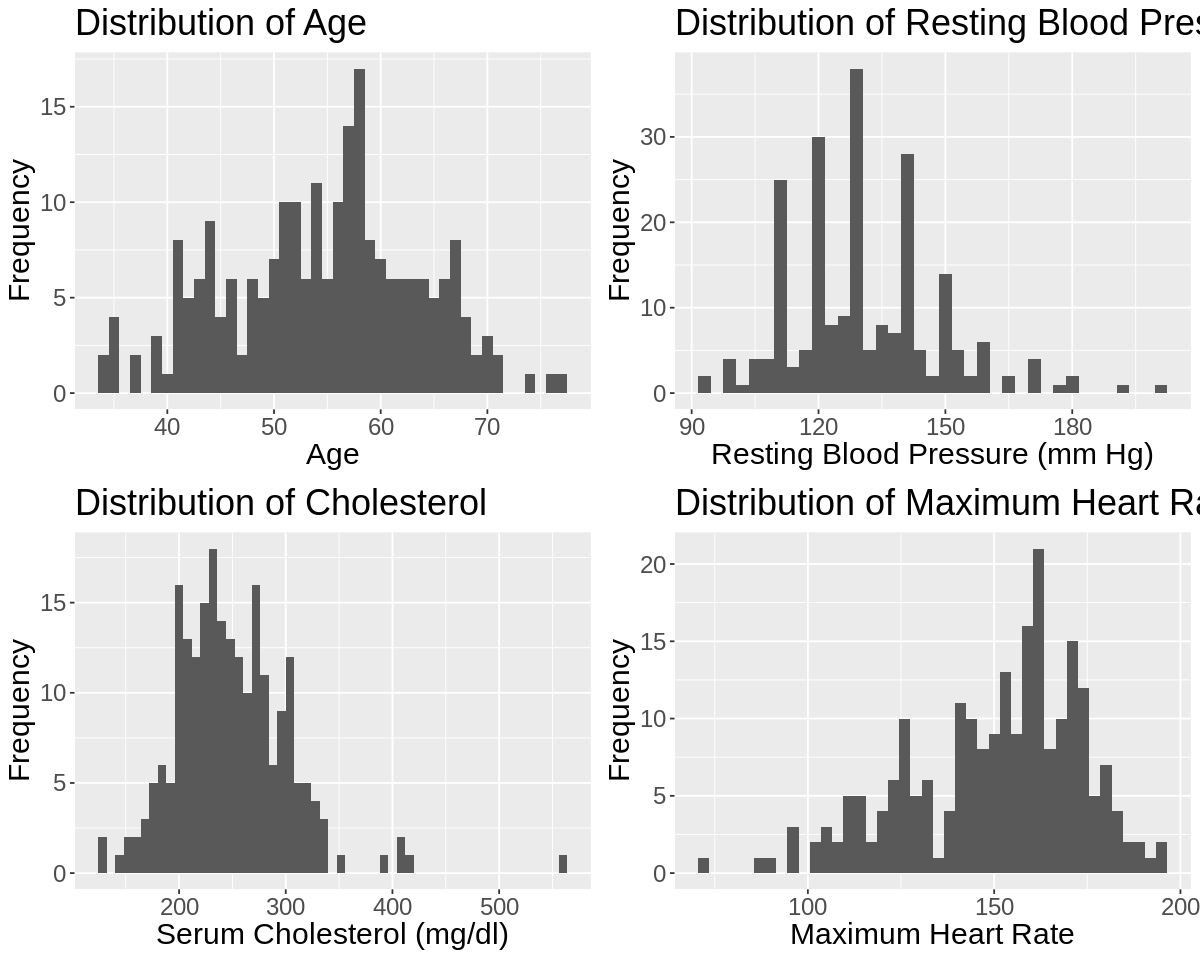

In [22]:
# age distribution
age_dist <- heart_disease_training |> 
    ggplot(aes(x = age)) +
    geom_histogram(binwidth = 1) +
    xlab("Age") +
    ylab("Frequency") +
    ggtitle("Distribution of Age") +
    theme(text = element_text(size = 18))

# trestbps distribution
trestbps_dist <- heart_disease_training |> 
    ggplot(aes(x = trestbps)) +
    geom_histogram(binwidth = 3) +
    xlab("Resting Blood Pressure (mm Hg)") +
    ylab("Frequency") +
    ggtitle("Distribution of Resting Blood Pressure") +
    theme(text = element_text(size = 18))

# chol distribution
chol_dist <- heart_disease_training |> 
    ggplot(aes(x = chol)) +
    geom_histogram(binwidth = 8) +
    xlab("Serum Cholesterol (mg/dl)") +
    ylab("Frequency") +
    ggtitle("Distribution of Cholesterol") +
    theme(text = element_text(size = 18))

# thalach distribution
thalach_dist <- heart_disease_training |> 
    ggplot(aes(x = thalach)) +
    geom_histogram(binwidth = 3) +
    xlab("Maximum Heart Rate") +
    ylab("Frequency") +
    ggtitle("Distribution of Maximum Heart Rate") +
    theme(text = element_text(size = 18))

# plot 4 histograms in one graph
options(repr.plot.height = 8, repr.plot.width = 10)
plot_grid(age_dist, trestbps_dist, chol_dist, thalach_dist, nrow = 2, ncol = 2)

The individuals are mostly between age 40 - 70 and are more centered around 50 - 60.
The majority have resting blood pressure between 120 - 140, cholesterol level between 200 - 300, and maximum heart rate between 150 - 180.

we can explore the correlation between these predictors by plotting scatterplots:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



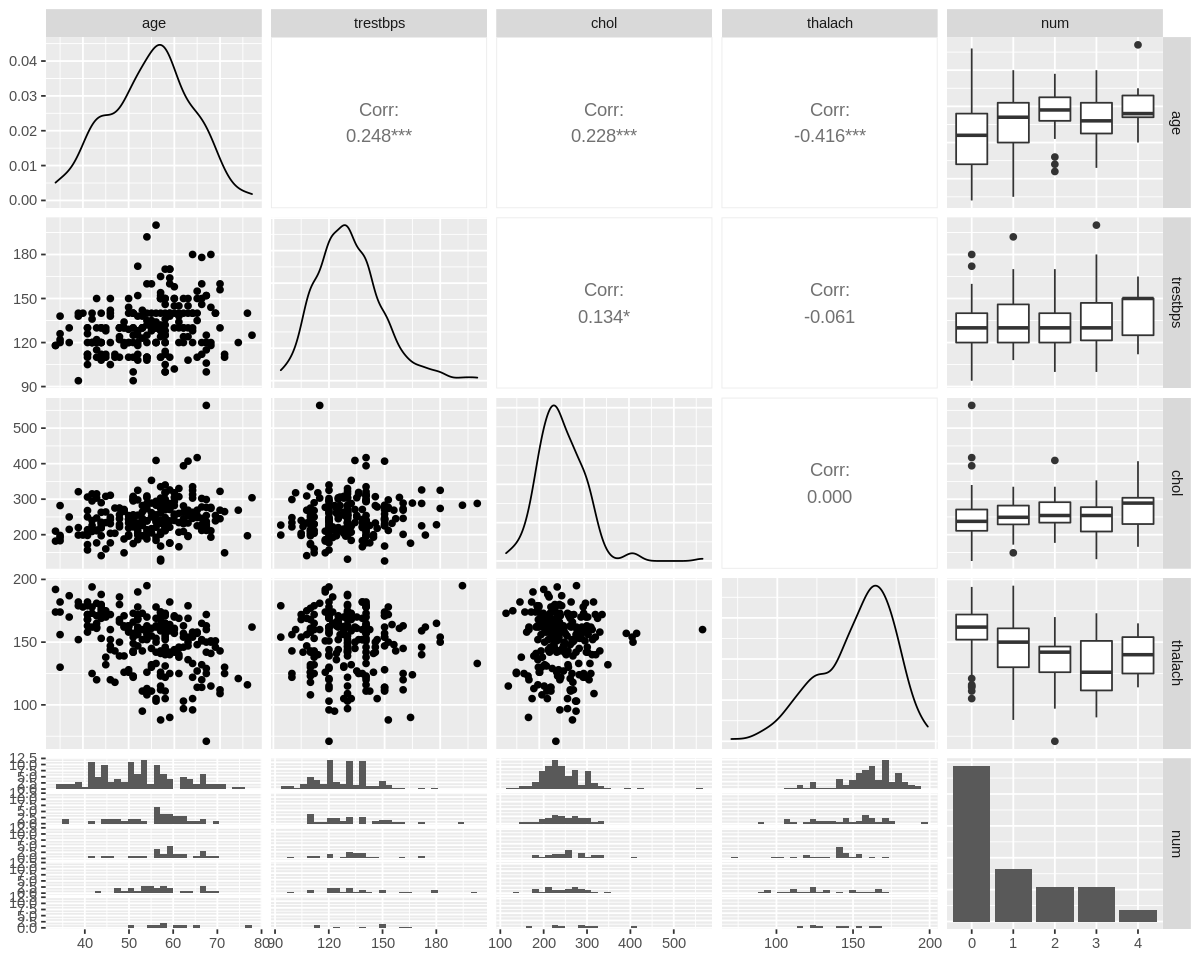

In [24]:
heart_disease_training |> 
    select(age, trestbps, chol, thalach, num) |> 
    ggpairs()

Age and trestbps appear to have a positive relationship, whilst age and thalach appear to have a negative relationship. Further than these 2, no other correlations between variables appear. While the mean of chol does not change much across these categories of num, the means of age and thalach do vary quite a lot. Moreover, only when num = 5 does the mean of trestbps grow significantly.

Now that we have completed the exploratory data analysis, we can create classification models to answer our research question.

To determine which predictor predicts the best, or with the highest accuracy, we first need to create a KNN model for each predictor. 

Generate a KNN classification model for age:

! Fold5: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



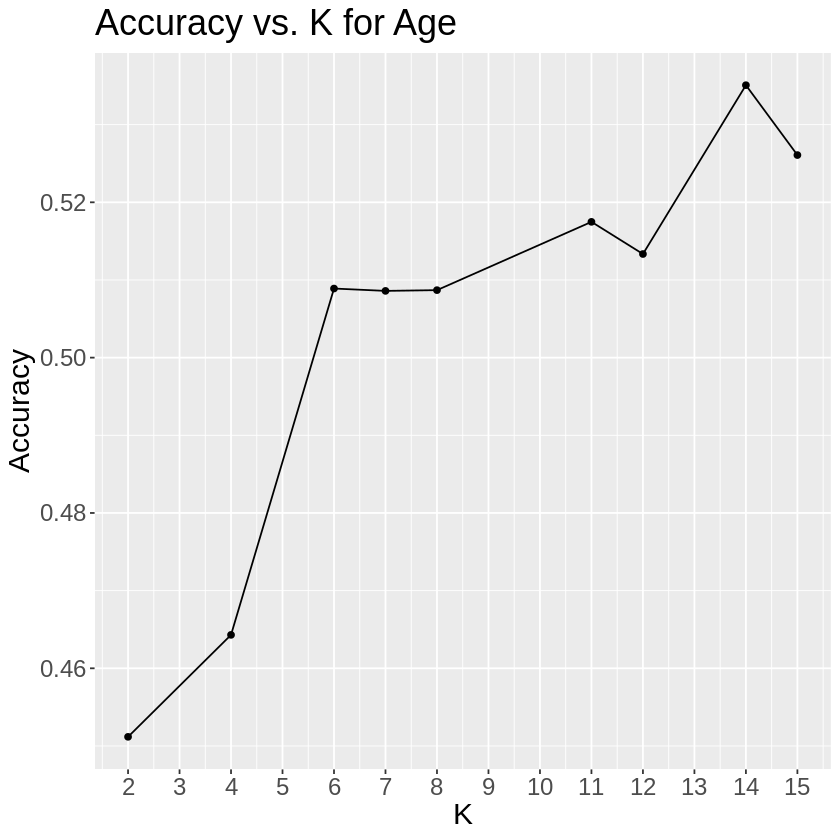

In [26]:
set.seed(9999) 
options(repr.plot.height = 7, repr.plot.width = 7)
# create a recipe
age_recipe <- recipe(num ~ age, data = heart_disease_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create a KNN classification model with k unspecified
age_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# perform cross validation 
age_vfold <- vfold_cv(heart_disease_training, v = 5, strata = num)

# fit the model and calculate the accuracy of each K values 
age_accuracy <- workflow() |>
    add_recipe(age_recipe) |>
    add_model(age_knn) |>
    tune_grid(resamples = age_vfold, grid = 10) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# plot the accuracy versus k graph
age_acc_plot <- age_accuracy |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "K", y = "Accuracy") +
    ggtitle("Accuracy vs. K for Age") +
    theme(text = element_text(size=18)) +
    scale_x_continuous(breaks = 2:15) 
age_acc_plot 

According to this graph, the accuracy is highest when K = 14 for age. However, it should be noted that even though the accuracy is the most at K = 14, this highest accuracy value only reaches 0.535 approximatley.

Generate a KNN classification model for trestbps (resting blood pressure in mm Hg):

! Fold5: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



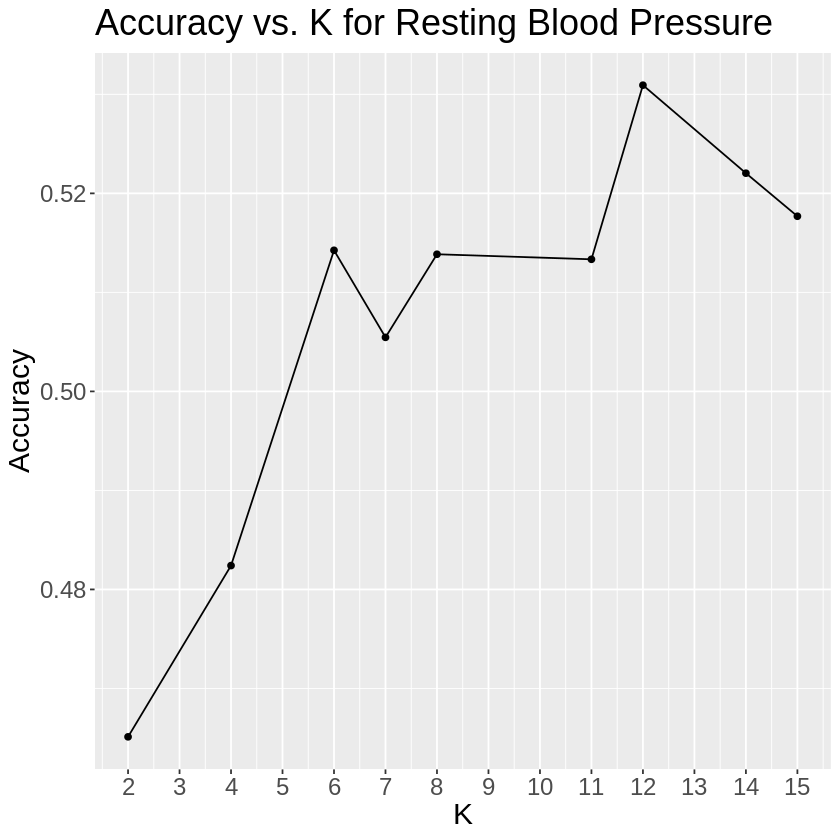

In [27]:
set.seed(9999) 

# create a recipe
trestbps_recipe <- recipe(num ~ trestbps, data = heart_disease_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create a KNN classification model with k unspecified
trestbps_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# perform cross validation 
trestbps_vfold <- vfold_cv(heart_disease_training, v = 5, strata = num)

# fit the model and calculate the accuracy of each K values 
trestbps_accuracy <- workflow() |>
    add_recipe(trestbps_recipe) |>
    add_model(trestbps_knn) |>
    tune_grid(resamples = trestbps_vfold, grid = 10) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# plot the accuracy versus k graph
trestbps_acc_plot <- trestbps_accuracy |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "K", y = "Accuracy") +
    ggtitle("Accuracy vs. K for Resting Blood Pressure") +
    theme(text = element_text(size=18)) +
    scale_x_continuous(breaks = 2:15) 
trestbps_acc_plot   

According to this graph, using trestbps, the highest accuracy is 0.53 approximately when K = 12.

Generate a KNN classification model for chol (serum cholesterol in mg/dl):

! Fold5: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



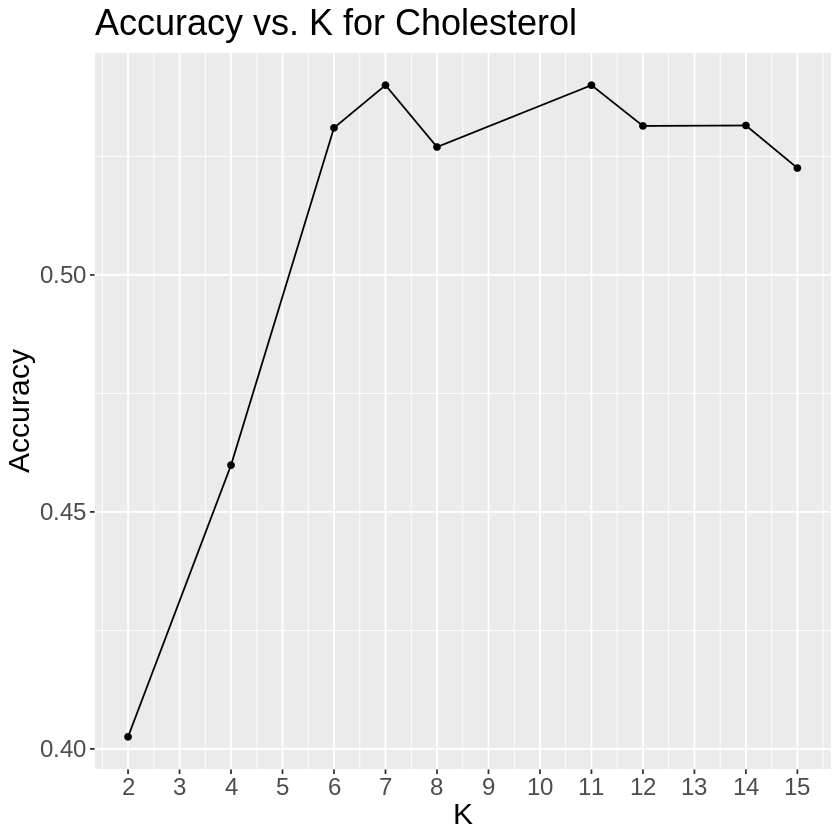

In [28]:
set.seed(9999) 

# create a recipe
chol_recipe <- recipe(num ~ chol, data = heart_disease_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create a KNN classification model with k unspecified
chol_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# perform cross validation 
chol_vfold <- vfold_cv(heart_disease_training, v = 5, strata = num)

# fit the model and calculate the accuracy of each K values 
chol_accuracy <- workflow() |>
    add_recipe(chol_recipe) |>
    add_model(chol_knn) |>
    tune_grid(resamples = chol_vfold, grid = 10) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# plot the accuracy versus k graph
chol_acc_plot <- chol_accuracy |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "K", y = "Accuracy") +
    ggtitle("Accuracy vs. K for Cholesterol") +
    theme(text = element_text(size=18)) +
    scale_x_continuous(breaks = 2:15) 
chol_acc_plot 

Using chol, the highest accuracy is a bit less than 0.55 when K = 7 or 11.

Generate a KNN classification model for thalach (maximum heart rate):

! Fold5: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



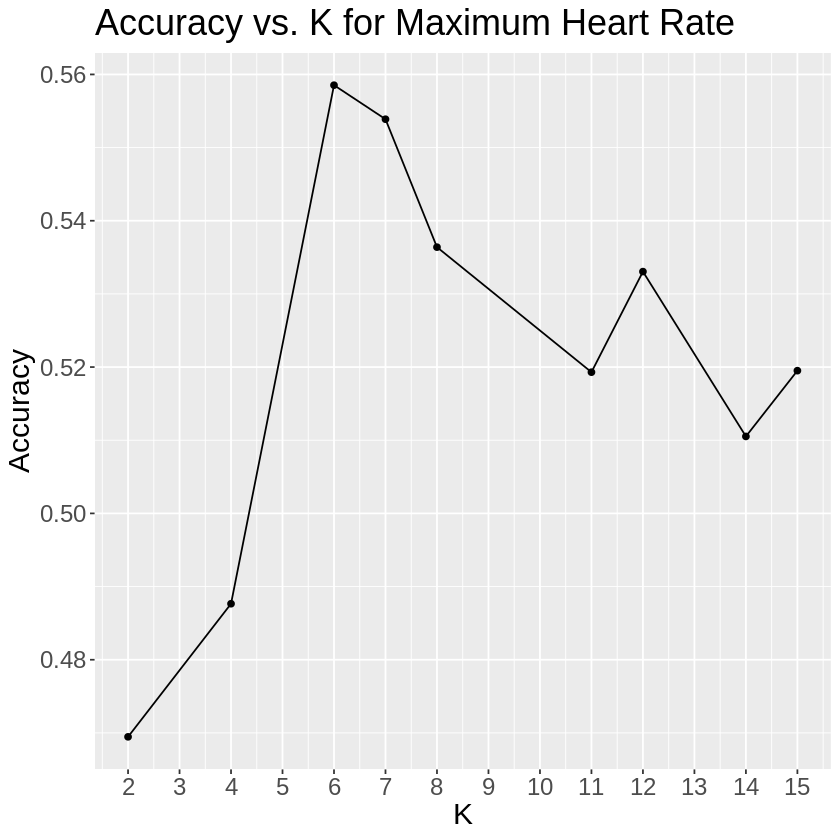

In [29]:
set.seed(9999) 

# create a recipe
thalach_recipe <- recipe(num ~ thalach, data = heart_disease_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create a KNN classification model with k unspecified
thalach_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# perform cross validation 
thalach_vfold <- vfold_cv(heart_disease_training, v = 5, strata = num)

# fit the model and calculate the accuracy of each K values 
thalach_accuracy <- workflow() |>
    add_recipe(thalach_recipe) |>
    add_model(thalach_knn) |>
    tune_grid(resamples = thalach_vfold, grid = 10) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# plot the accuracy versus k graph
thalach_acc_plot <- thalach_accuracy |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "K", y = "Accuracy") +
    ggtitle("Accuracy vs. K for Maximum Heart Rate") +
    theme(text = element_text(size=18)) +
    scale_x_continuous(breaks = 2:15) 
thalach_acc_plot 

Using thalach, the highest accuracy is 0.56 when K = 6.

To compare which variable predicts the best, we put all 4 lines in each Accuracy vs. K graph together.

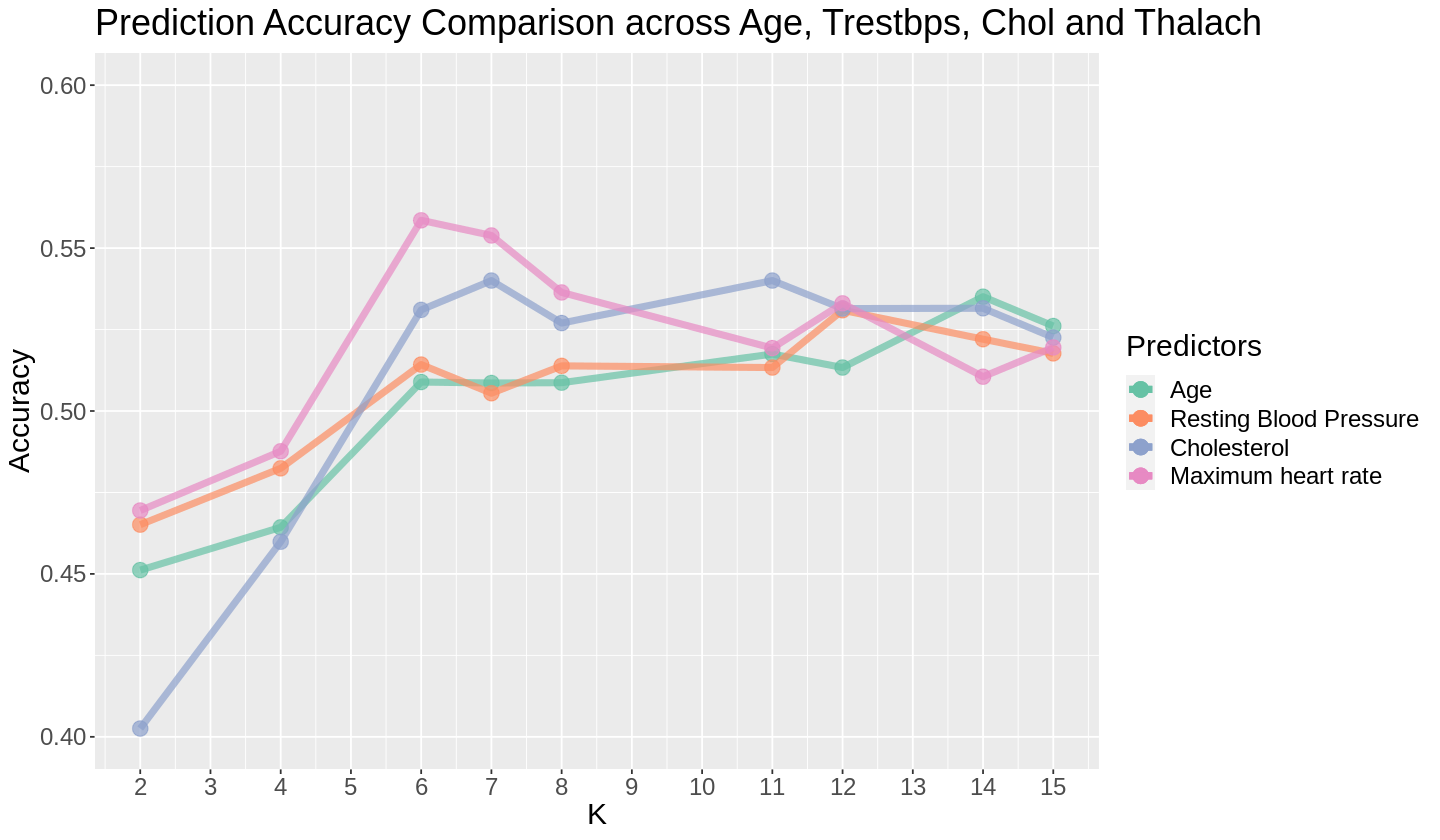

In [109]:
options(repr.plot.height = 7, repr.plot.width = 12)
compare_plot <- ggplot() +
    geom_line(data = age_accuracy, aes(x = neighbors, y = mean, color = "Age"), lwd = 2, alpha = 0.7) +
    geom_point(data = age_accuracy, aes(x = neighbors, y = mean, color = "Age"), size = 4, alpha = 0.7) +
    geom_line(data = trestbps_accuracy, aes(x = neighbors, y = mean, color = "Resting Blood Pressure"), lwd = 2, alpha = 0.7) +
    geom_point(data = trestbps_accuracy, aes(x = neighbors, y = mean, color = "Resting Blood Pressure"), size = 4, alpha = 0.7) +
    geom_line(data = chol_accuracy, aes(x = neighbors, y = mean, color = "Cholesterol"), lwd = 2, alpha = 0.7) +
    geom_point(data = chol_accuracy, aes(x = neighbors, y = mean, color = "Cholesterol"), size = 4, alpha = 0.7) +
    geom_line(data = thalach_accuracy, aes(x = neighbors, y = mean, color = "Maximum heart rate"), lwd = 2, alpha = 0.7) +
    geom_point(data = thalach_accuracy, aes(x = neighbors, y = mean, color = "Maximum heart rate"), size = 4, alpha = 0.7) +
    theme(text = element_text(size = 18)) +
    labs(x = "K", y = "Accuracy") +
    scale_color_manual(name = "Predictors",
                       values = c("Age"="#66c2a5", "Resting Blood Pressure"="#fc8d62", "Cholesterol"="#8da0cb", "Maximum heart rate"="#e78ac3"),
                       breaks = c("Age", "Resting Blood Pressure", "Cholesterol", "Maximum heart rate")) +
    ggtitle("Prediction Accuracy Comparison across Age, Trestbps, Chol and Thalach") +
    scale_x_continuous(breaks = 2:15) +
    ylim(c(0.40, 0.60))

compare_plot  

When K < 9, maximum heart rate (thalach) predicts the best; when 9 < K < 12, cholesterol (chol) predicts the best; when K > 12, all these 4 predictors have roughly the same accuracy. The highest prediction accuracy, which is achieved using thalach as the predictor and setting K = 6, is only 0.56 approximately.

Next, we can create a KNN classification model using all predcitors - age, trestbps, chol, thalach - and see how well it can predict.

! Fold5: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



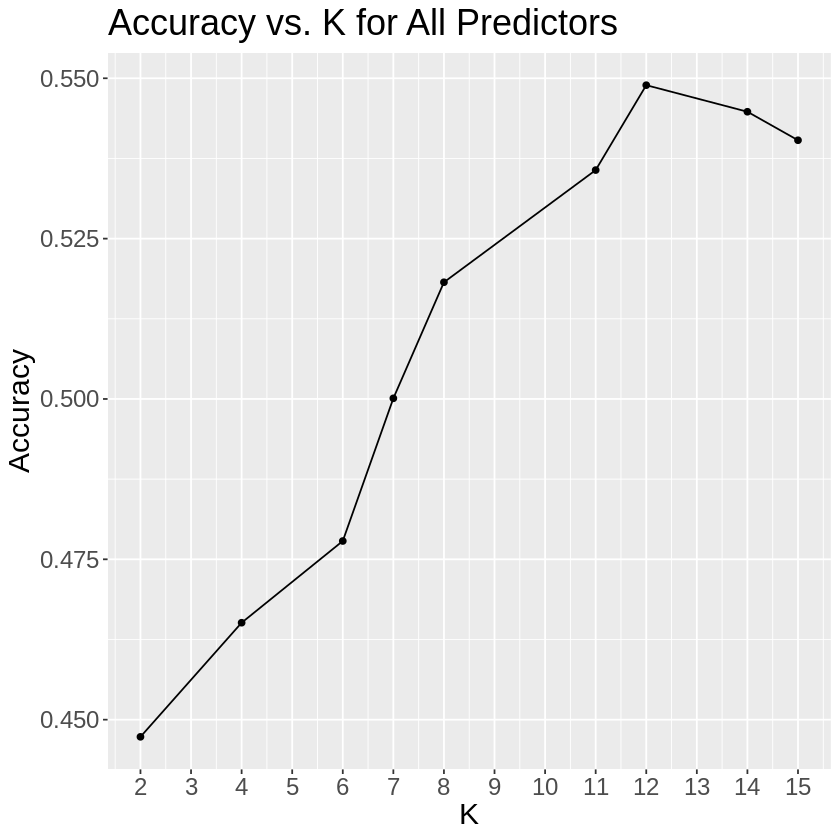

In [112]:
set.seed(9999) 

# create a recipe using all 4 predictors 
all_recipe <- recipe(num ~  age + trestbps + chol + thalach, data = heart_disease_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create a KNN classification model with k unspecified
all_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# perform cross validation 
all_vfold <- vfold_cv(heart_disease_training, v = 5, strata = num)

# fit the model and calculate the accuracy of each K values 
all_accuracy <- workflow() |>
    add_recipe(all_recipe) |>
    add_model(all_knn) |>
    tune_grid(resamples = all_vfold, grid = 10) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

# plot the accuracy versus k graph 
options(repr.plot.height = 7, repr.plot.width = 7)
all_acc_plot <- all_accuracy |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "K", y = "Accuracy") +
    ggtitle("Accuracy vs. K for All Predictors") +
    theme(text = element_text(size=18)) +
    scale_x_continuous(breaks = 2:15) 
all_acc_plot 

According to this graph, the accuracy is highest when K = 12; therefore, we can specify neighbors = 12 when generating the KNN model using all 4 predictors. However, it should be noted that even though the accuracy is the most at K = 12, this highest accuracy value only reaches 0.55 approximatley, which means the model only predicts 55% of the training data correctly. Furthermore, this highest accuracy value does not differ much compared to the models using only one of the 4 variables as the predictor.

In [113]:
# generate the best KNN classification model, specifying K = 12
all_knn_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) |>
    set_engine("kknn") |>
    set_mode("classification")

# fit the training data using the best model
all_fit <- workflow() |> 
    add_recipe(all_recipe) |> 
    add_model(all_knn_best) |> 
    fit(data = heart_disease_training)

# predict the test dataset using the fit model
all_predict <- predict(all_fit, heart_disease_testing) |> 
    bind_cols(heart_disease_testing) |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy")
all_predict

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4545455


Using the KNN classification model we created above with all 4 predictors, we only predicts 45% of the test dataset correctly (not good).

We can take a closer look to the confusion matrix.

In [116]:
predict(all_fit, heart_disease_testing) |> 
    bind_cols(heart_disease_testing) |>
    conf_mat(truth = num, estimate = .pred_class)

          Truth
Prediction  0  1  2  3  4
         0 33 11  5  5  3
         1  4  1  4  1  1
         2  0  1  0  1  0
         3  5  1  0  1  0
         4  0  0  0  0  0

Only 35 values are properly predicted by our model (33 num=0, 1 num=1, 1 num=3), while the remaining 42 values are wrong. 9 numbers should be 0 (no heart disease), however according to our model, they will either be 1 or 3 (with heart disease). More critically, there are 24 values that, in fact, are 1, 2, 3, or 4, but are predicted to be 0, indicating that there are 24 people who actually have heart disease, but are not predicted to have it by our model. As a result of our inaccurate predictions, these patients may not receive the proper therapy, which can have fatal effects.